HomeWork 3's Report:

Tasks:
1. Change the Hyperparameters or reward function to reach a better performance(for lab 7)
2. train a deep RL agent on a different Gym enviroment


Introduction

The main tasks of this homework was written above. Therefor my first step is to use Lab 7 enviroment and try to enhance the performance of that RL agent. My second task is to creat another RL agent to solve the Acrobat Gym enviroment. 

The goal of the agent is to interact with the emulator(enviroment) by selecting actions in a way that maximizes future rewards. In order to do so, we have to optimize the functionQ*(s,a)(action-reward function) which s is some (previous)sequences and a is an action.

The basic idea behind many reinforcement learning algorithms is to estimate the action-value function, by using the Bellman equation as an iterative update. But this is impractical. Instead, it is common to use a function approximator to estimate the action-value function. In the reinforcement learning community this is typically a linear function approximator, but sometimes a non-linear function approximator is used instead, such as a neural network(DQN).

In this homework the loss function was Huber-loss function(Smooth-L1-Loss)

Methods

1. Replay Memory:

It is a function used in the training steps to push the tuple of state, action, next state and reward into the memory. The memory itself has a specified capacity. This function can also sample from the previous memories which will be useful in the training steps as well.

2. DQN:

It is the deeep neural network that will be used as an agent in the architecture. The network used for lab 7 and Acrobot is same with two hidden layers(first one with 64 neurons and second one with 4096) and ReLU function as the actiovation function. The  The input is state space and output will be action space(in lab 7 state space was 4 and action space was 2. Acrobot, however, has 6 state space and 3 action space).

3. Epsilon Greedy:

Epsilon Greedy is one of the action policies to choose an action. In this policy, first one find out the best action which is the output of the deep network then with probability of equal or greater than epsilon will choose it. Otherwise he or she can choose a random action(among the action space).

4. Softmax:

Softmax is another policy to choose an action. In this policy there is a variable which is like a temprature. at zero temprature it will always choose the best action(output of the network) but in other tempratures it chooses the action from a softmax distribution. The temprature itself also come from exploration profile which is a decay function from a variable number to zero with specified number of steps.

5. Training:

In training first state will be the first enviroment step and then use softmax policy for action. Then go to the next state by using the action, keep track of the reward and pushing the previous state, action, next state and reward to the memory. In this stage we can also implement a strategy for reward to enhance the performance of the agent. We repeat this process until we reach a minimum number for training, then we use the update step function which will use both policy network and target network to increase performance of the agent and actully solve the problem.

6. Update step:

this function is representing the main concept of an RL agent and its funtionality. It samples uniformly from previous observations(from replay memory) and set the next output equal to the sample reward if it is the last state otherwise set the it to sample reward plus the best action(from DQN) with a discounted factor(gamma). Then it tries to minimize the loss function(between the next output and the output of DQN).  

Results

The firs part of task which was related to cartpole enviroment was solved by a RL agent after about 500 steps.( after 500 steps the agent was able to choose the action optimaly to solve the enviroment and get maximum reward). 

The second part of the homework was related to Acrobot enviroment which the ralted RL agent was able to solve the problem and got maximum reward after about 500 steps.




Some imports and installations

In [1]:
!pip install gym

import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch import nn
from collections import deque,namedtuple

!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [76.4 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 https://developer.download.nvidia.com

Some prepration essential for Colab

In [2]:
display = Display(visible=0, size=(1400, 900))
display.start()

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1
      
def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

Lab 7

In [3]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        # TODO: Add the tuple (state, action, next_state, reward) to the queue
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

In [4]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
            # TODO
            nn.Linear(in_features= state_space_dim, out_features= 64),
            nn.ReLU(),
            nn.Linear(in_features= 64, out_features= 64*64),
            nn.ReLU(),
            nn.Linear(in_features= 64*64, out_features= action_space_dim)
                )

    def forward(self, x):
        x = x.to(device)
        return self.linear(x)

In [5]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.cpu().numpy()

In [6]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).cpu().numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.cpu().numpy()

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

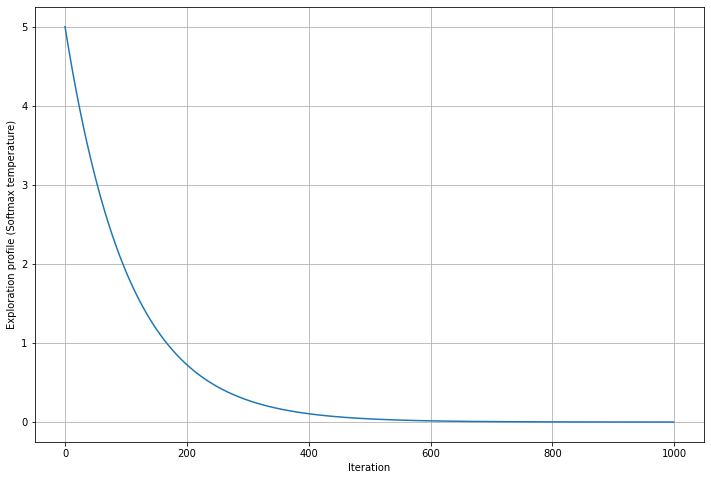

In [7]:
### Define exploration profile
initial_value = 5
num_iterations = 1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

In [8]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


In [9]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.99   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-3   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 256   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim).to(device)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim).to(device)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [11]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32, device= device)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64  , device= device)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32, device= device)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32, device= device) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a_t)
    state_action_values = q_values.gather(1, actions.unsqueeze(1).cuda())

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size, device= device)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

In [12]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

plotting_rewards=[]

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # We apply a (linear) penalty when the cart is far from center
      pos_weight = 1
      reward = reward - pos_weight * np.abs(state[0])

      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    plotting_rewards.append(score)
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 11.51335996967354 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 16.430104785390274 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 37.97605914666466 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 18.524934680846943 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 23.614309882068863 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: 15.126022117879057 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 27.879917316861167 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 28.446271329524947 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 14.496291515991532 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 20.251846335095117 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 28.820184073980002 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 49.24488960074766 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL S

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


EPISODE: 43 - FINAL SCORE: 29.419607756164513 - Temperature: 3.3329558686227982
EPISODE: 44 - FINAL SCORE: 48.479117569923794 - Temperature: 3.300925656226998
EPISODE: 45 - FINAL SCORE: 41.775577432993614 - Temperature: 3.2692032590398465
EPISODE: 46 - FINAL SCORE: 13.463898587332844 - Temperature: 3.237785718910413
EPISODE: 47 - FINAL SCORE: 25.202286071400483 - Temperature: 3.206670106116043
EPISODE: 48 - FINAL SCORE: 19.68193608336031 - Temperature: 3.175853519089164
EPISODE: 49 - FINAL SCORE: 30.08588633898905 - Temperature: 3.145333084146709
EPISODE: 50 - FINAL SCORE: 41.588727137241946 - Temperature: 3.115105955222141
Updating target network...
EPISODE: 51 - FINAL SCORE: 18.21341489739679 - Temperature: 3.0851693136000553
EPISODE: 52 - FINAL SCORE: 20.776349852421973 - Temperature: 3.0555203676533305
EPISODE: 53 - FINAL SCORE: 21.209251334142387 - Temperature: 3.0261563525828072
EPISODE: 54 - FINAL SCORE: 11.318188483505896 - Temperature: 2.9970745301594635
EPISODE: 55 - FINAL SC

No handles with labels found to put in legend.


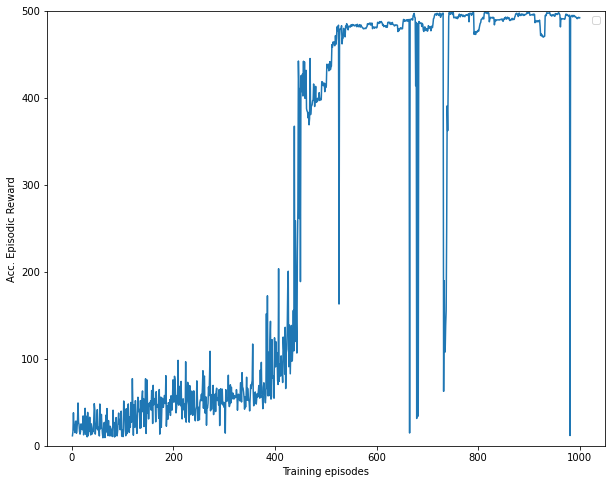

In [13]:
plt.figure(figsize=(10,8))
plt.plot(range(1,1001),plotting_rewards)
plt.xlabel('Training episodes')
plt.ylabel('Acc. Episodic Reward')
plt.ylim([0,500])
plt.legend()
plt.show()

In [14]:
env = gym.make('CartPole-v1') 
env.seed(1) 

env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

plotting_rewards2=[]
# Let's try for a total of 10 episodes
for num_episode in range(10):
  
    state = env.reset()
    score = 0
    done = False
    
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (-1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
    plotting_rewards2.append(score)
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
    
env.close()

EPISODE 1 - FINAL SCORE: 500.0
EPISODE 2 - FINAL SCORE: 500.0
EPISODE 3 - FINAL SCORE: 500.0
EPISODE 4 - FINAL SCORE: 500.0
EPISODE 5 - FINAL SCORE: 500.0
EPISODE 6 - FINAL SCORE: 500.0
EPISODE 7 - FINAL SCORE: 500.0
EPISODE 8 - FINAL SCORE: 500.0
EPISODE 9 - FINAL SCORE: 500.0
EPISODE 10 - FINAL SCORE: 500.0


No handles with labels found to put in legend.


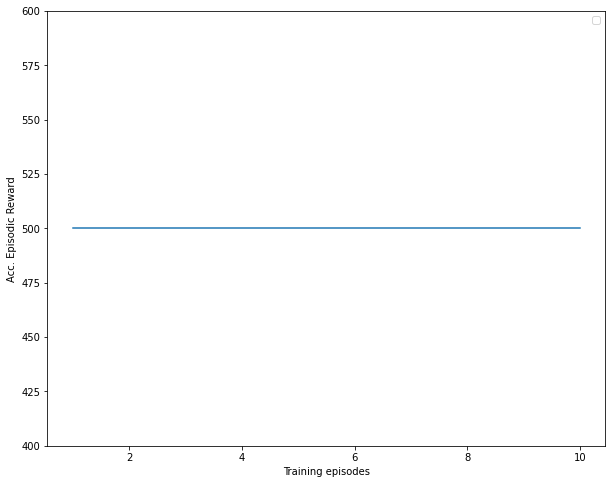

In [15]:
plt.figure(figsize=(10,8))
plt.plot(range(1,11),plotting_rewards2)
plt.xlabel('Training episodes')
plt.ylabel('Acc. Episodic Reward')
plt.ylim([400,600])
plt.legend()
plt.show()

Acrobot

In [16]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, next_state, reward):
        # Add the tuple (state, action, next_state, reward) to the queue
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) 
        return random.sample(self.memory,batch_size)

    def __len__(self):
        return len(self.memory)

In [17]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                  nn.Linear(state_space_dim,64),
                  nn.ReLU(),
                  nn.Linear(64,64*2),
                  nn.ReLU(),
                  nn.Linear(64*2,action_space_dim)
                )

    def forward(self, x):
        x = x.to(device)
        return self.linear(x)

In [18]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions (this list includes all the actions but the optimal one)
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly from non_optimal_actions
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.cpu().numpy()

In [19]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out/temperature, dim=0).cpu().numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    action = np.random.choice(all_possible_actions,p=softmax_out)
    
    return action, net_out.cpu().numpy()

In [20]:
### Define exploration profile
initial_value = 5
num_iterations = 1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) 
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

In [21]:
# environment
env = gym.make('Acrobot-v1') 
env.seed(0) # Set a random seed for the environment 

state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

# Set random seeds
torch.manual_seed(0)
np.random.seed(0)

gamma = 0.99  
replay_memory_capacity = 10000   
lr = 1e-3
target_net_update_steps = 10   
batch_size = 256   
bad_state_penalty = 0   
min_samples_for_training = 1000   

# replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

# policy network
policy_net = DQN(state_space_dim, action_space_dim).to(device)

# target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim).to(device)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

loss_fn = nn.SmoothL1Loss()

STATE SPACE SIZE: 6
ACTION SPACE SIZE: 3


In [22]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32, device=device)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64  , device=device)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32, device=device)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32, device=device) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute Q values 
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1).cuda())

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size, device=device)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1)# Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping 
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

In [23]:
env = gym.make('Acrobot-v1') 
env.seed(0) 

env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

plotting_rewards=[]

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    state = env.reset()
    score = 0
    done = False

    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      next_state, reward, done, info = env.step(action)

      
      reward = (reward) * int(-np.cos(state[0]) - np.cos(state[0] + state[1]))

      # Update the final score (-1 for each step)
      score += reward

      if done:  
          reward += bad_state_penalty
          next_state = None
      
      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment 
      env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
    
    plotting_rewards.append(score)
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: -500.0 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: -500.0 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: -500.0 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: -500.0 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: -500.0 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: -500.0 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: -500.0 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: -500.0 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: -500.0 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: -500.0 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: -500.0 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: -500.0 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: -500.0 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: -500.0 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: -50

No handles with labels found to put in legend.


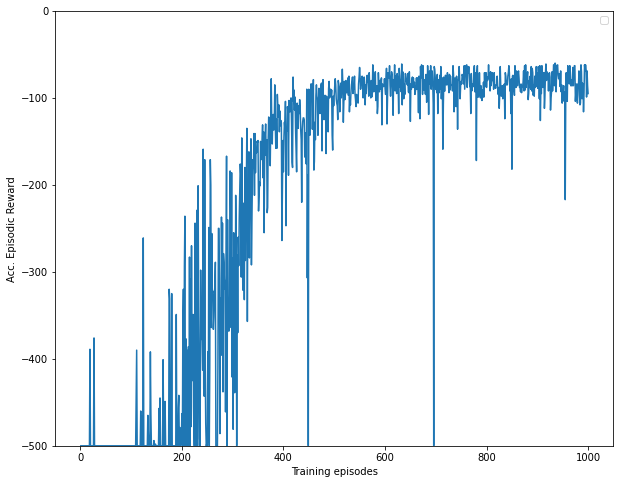

In [24]:
plt.figure(figsize=(10,8))
plt.plot(range(1,1001),plotting_rewards)
plt.xlabel('Training episodes')
plt.ylabel('Acc. Episodic Reward')
plt.ylim([-500,0])
plt.legend()
plt.show()

In [25]:
env = gym.make('Acrobot-v1') 
env.seed(1) 

env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

plotting_rewards2=[]
# Let's try for a total of 10 episodes
for num_episode in range(10):
  
    state = env.reset()
    score = 0
    done = False
    
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (-1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
    plotting_rewards2.append(score)
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
    
env.close()

EPISODE 1 - FINAL SCORE: -85.0
EPISODE 2 - FINAL SCORE: -74.0
EPISODE 3 - FINAL SCORE: -76.0
EPISODE 4 - FINAL SCORE: -93.0
EPISODE 5 - FINAL SCORE: -74.0
EPISODE 6 - FINAL SCORE: -86.0
EPISODE 7 - FINAL SCORE: -89.0
EPISODE 8 - FINAL SCORE: -85.0
EPISODE 9 - FINAL SCORE: -90.0
EPISODE 10 - FINAL SCORE: -79.0


No handles with labels found to put in legend.


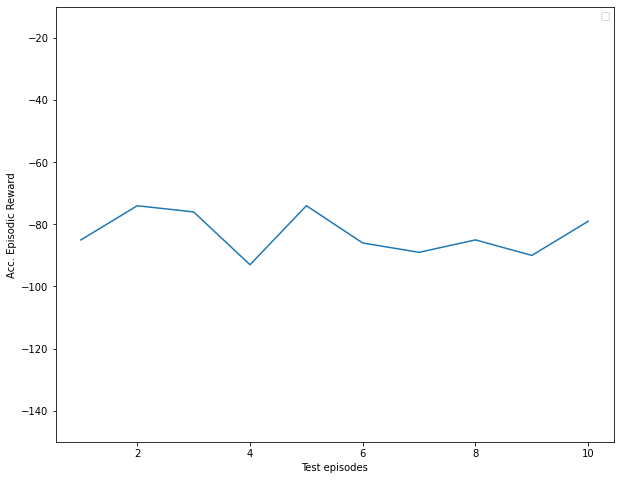

In [26]:
plt.figure(figsize=(10,8))
plt.plot(range(1,11),plotting_rewards2)
plt.xlabel('Test episodes')
plt.ylabel('Acc. Episodic Reward')
plt.ylim([-150,-10])
plt.legend()
plt.show()